---
title: "Predicting survival post alloHCT using Machine Learning"
author: "Asif Adil"
date: "11-18-2025"
data-modified: last-modified
abstract: "This notebook develops and evaluates machine learning models to predict post-alloHCT survival outcomes at multiple time horizons (100 days, 1 year, 2 years, 3 years). We employ a comprehensive pipeline with feature selection, preprocessing, hyperparameter tuning via grid search, and calibrated classifiers across three model families (Logistic Regression, Gradient Boosting, Random Forest). Model performance is assessed using stratified cross-validation with metrics including AUROC, AUPRC, and calibration curves, with SHAP analysis for interpretability."
execute:
    freeze: true
    warnings: false
format:
    html:
    echo: false
    embe-resources: true
    toc: true
    toc_float: true
    number_sections: true
    theme: united
    df_print: paged
    anchor-sections: true
    smooth_scroll: true
    link-external-icon: true
    link-external-newwindow: true
    code-fold: true
    code-line-numbers: true
    highlight-style: github
---

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import glob, os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


# remove warnings
import warnings
warnings.filterwarnings('ignore')

from pyprojroot import here

In [3]:
# Add the project root to sys.path
sys.path.append(str(here()))

from hspc.config import get_config
config = get_config()

In [4]:
import os, warnings, math, json
import numpy as np
import pandas as pd

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import (
    roc_auc_score, average_precision_score, brier_score_loss,
    accuracy_score, precision_score, recall_score, f1_score, balanced_accuracy_score, precision_recall_curve,
    roc_curve
)
from sklearn.calibration import calibration_curve
import joblib
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from collections import Counter


from allosurv.allosurv import ( make_preprocessor, 
                               make_models_and_grids,
                               make_labels,
                               evaluate,
                               plot_roc_pr_cal,
                               plot_shap_for_horizon,
                               plot_performance_curves,
)

In [5]:
HORIZONS = {'100d':100,'1y':365,'2y':730,'3y':1095}

In [6]:
df = pd.read_csv(here() / config.data_processed / "Aryans_Top25medications_processed.csv")

In [7]:
df

,record_id,pat_gender,pat_ethnicity,vital_status,survival_days,disease_category,transplant_age,stem_cell_source,donor_type,recipient_type,...,potassiumchloride,amlodipine,lorazepam,melatonin,loperamide,ursodiol,acetaminophen,olanzapine,polyethyleneglycol,gabapentin
0,1,0,Not Hispanic or Latino (Race:Black or African ...,0,211,Severe aplastic anemia (SAA),12,MRD,A+,O+,...,0,0,1,0,0,0,1,0,0,0
1,2,1,Not Hispanic or Latino (Race:White),0,210,Acute lymphoblastic leukemia (ALL),37,MUD,O+,O+,...,0,0,1,0,0,1,0,0,0,0
2,3,0,Hispanic or Latino (Race:White),0,210,Acute Myeloid Leukemia (AML),71,MUD,O+,A+,...,0,0,0,1,0,0,0,1,0,0
3,4,1,Not Hispanic or Latino (Race:White),0,208,Non-Hodgkin lymphoma (NHL),64,MUD,A+,O+,...,1,0,0,0,0,1,0,0,0,0
4,5,1,Not Hispanic or Latino (Race:White),0,204,Acute Myeloid Leukemia (AML),50,MRD,O+,O-,...,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,496,1,Not Hispanic or Latino (Race:White),1,50,Myelodysplastic syndrome (MDS),66,MUD,B-,O-,...,1,0,0,0,0,0,0,0,0,1
496,497,1,Not Hispanic or Latino (Race:White),0,2317,Acute Myeloid Leukemia (AML),43,HRD,O+,A+,...,1,0,1,0,0,0,0,1,0,0
497,498,1,Not Hispanic or Latino (Race:White),1,44,Acute Myeloid Leukemia (AML),44,MUD,A+,O+,...,0,0,0,0,0,0,1,1,1,0
498,499,0,Not Hispanic or Latino (Race:Black or African ...,0,2309,Acute lymphoblastic leukemia (ALL),38,MUD,O+,O-,...,0,0,0,1,0,0,0,0,0,0


In [8]:
cat_cols = ['pat_gender','pat_ethnicity','disease_category','stem_cell_source','donor_type','recipient_type','conditioning_type',
            'acyclovir', 'fluconazole', 'sulfamethoxazole-trimethoprim',
       'tacrolimus', 'mycophenolatemofetil', 'ondansetron', 'sirolimus',
       'letermovir', 'prochlorperazine', 'pantoprazole', 'magnesiumoxide',
       'multivitamin/supplement', 'oxycodone', 'promethazine',
       'cholecalciferol', 'potassiumchloride', 'amlodipine', 'lorazepam',
       'melatonin', 'loperamide', 'ursodiol', 'acetaminophen', 'olanzapine',
       'polyethyleneglycol', 'gabapentin']

In [9]:
# ==== Simple feature selection ====
# Keep obvious structured columns: numeric + short categorical
num_candidates = [c for c in df.columns if any(k in c.lower() for k in ['age','dose','pre','anc','wbc','rbc','plt','hgb','mcv', 'hla_match'])]
# add explicitly if present
for c in ['pat_age','transplant_age','cd34_dose','tbi_dose_max','rbc_pre','wbc_pre','plt_pre','hgb_pre','anc_pre','mcv_pre']:
    if c in df.columns and c not in num_candidates: num_candidates.append(c)

cat_candidates = [c for c in cat_cols if c in df.columns]
# cat_candidates = [c for c in ['pat_gender','pat_ethnicity','disease_category','stem_cell_source','donor_type', 'hla_matching','recipient_type','conditioning_type'] if c in df.columns]

feature_cols = sorted(set(num_candidates + cat_candidates))
# remove rbc_mo1.1  and pat_age from the features because it is redundant with rbc_pre
if 'rbc_mo1.1' in feature_cols:
    feature_cols.remove('rbc_mo1.1')
if 'pat_age' in feature_cols:
    feature_cols.remove('pat_age')
X = df[feature_cols].copy()
print('Using', len(feature_cols), 'features')

Using 70 features


In [10]:
all_results = []
best_models = {}
best_model_performances = {}
# create a datastructure whcich we can later utilize for plotting all the roc, prcurve, and calibration plots of each horizon in one single plot respectively
all_metrics = {}

for hname, T in HORIZONS.items():
    print(f'\n=== Horizon {hname} (T={T}) ===')
    y = make_labels(df, T)
    m = ~y.isna()
    Xh, yh = X[m], y[m].astype(int)

    pre = make_preprocessor(Xh)
    models, grids = make_models_and_grids()
    outer = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    fold_metrics = []
    y_all_prob, y_all_true = [], []

    for k, (tr, te) in enumerate(outer.split(Xh, yh), start=1):
        Xtr, Xte = Xh.iloc[tr], Xh.iloc[te]
        ytr, yte = yh.iloc[tr], yh.iloc[te]

        best_auc, best_model = -np.inf, None
        for mname, clf in models.items():
            pipe = Pipeline([('prep', pre), ('clf', clf)])
            gs = GridSearchCV(pipe, grids[mname], scoring='roc_auc', cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=42), n_jobs=-1, refit=True)
            gs.fit(Xtr, ytr)
            cal = CalibratedClassifierCV(gs.best_estimator_, cv=3, method='isotonic')
            cal.fit(Xtr, ytr)
            yprob = cal.predict_proba(Xte)[:,1]
            auc = roc_auc_score(yte, yprob)
            if auc > best_auc:
                best_auc, best_model = auc, cal

        yprob = best_model.predict_proba(Xte)[:,1]
        ypred = (yprob>=0.5).astype(int)
        metr = evaluate(yte, yprob, ypred); metr['Fold']=k; fold_metrics.append(metr)
        y_all_prob.extend(yprob.tolist()); y_all_true.extend(yte.tolist())

    res = pd.DataFrame(fold_metrics).mean(numeric_only=True)
    print('Mean metrics over 5 folds:\n', res[['AUROC','AUPRC','Brier','Accuracy','Precision','Recall','F1','BalancedAcc']])

    # Refit best family on all labeled data
    # Pick family by higher mean AUROC from the two models trained on full data with CV
    fam_scores = {}
    for mname, clf in models.items():
        pipe = Pipeline([('prep', pre), ('clf', clf)])
        gs = GridSearchCV(pipe, grids[mname], scoring='roc_auc', cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=42), n_jobs=-1, refit=True)
        gs.fit(Xh, yh)
        fam_scores[mname] = gs.best_score_
    best_family = max(fam_scores, key=fam_scores.get)
    gs = GridSearchCV(Pipeline([('prep', pre), ('clf', models[best_family])]), grids[best_family], scoring='roc_auc', cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=42), n_jobs=-1, refit=True)
    gs.fit(Xh, yh)
    cal_full = CalibratedClassifierCV(gs.best_estimator_, cv=3, method='isotonic')
    cal_full.fit(Xh, yh)
    
    # for each best model, store its performance metrics like AUROC, AUPRC, etc. to plot later
    best_model_performances[hname] = evaluate(np.array(y_all_true), np.array(y_all_prob), (np.array(y_all_prob)>=0.5).astype(int))
    performance_df = pd.DataFrame.from_dict(best_model_performances, orient='index')
    print(f'\nBest model performances for horizon {hname}:\n', performance_df)
    

    joblib.dump(cal_full, f'outputs/best_model_{hname}.joblib')
    best_models[hname] = f'outputs/best_model_{hname}.joblib'

    # plot_roc_pr_cal(np.array(y_all_true), np.array(y_all_prob), f'{hname} ({best_family})')
    
    # for each horizon, plot roc in a single figure
    all_results.append( (hname, np.array(y_all_true), np.array(y_all_prob)) )



=== Horizon 100d (T=100) ===
Mean metrics over 5 folds:
 AUROC          0.963552
AUPRC          0.905731
Brier          0.016419
Accuracy       0.982000
Precision      0.952778
Recall         0.836111
F1             0.884565
BalancedAcc    0.915858
dtype: float64

Best model performances for horizon 100d:
          AUROC     AUPRC     Brier  Accuracy  Precision    Recall        F1  \
100d  0.968102  0.890848  0.016419     0.982   0.948718  0.840909  0.891566   

      BalancedAcc  
100d     0.918262  

=== Horizon 1y (T=365) ===
Mean metrics over 5 folds:
 AUROC          0.797078
AUPRC          0.653332
Brier          0.127536
Accuracy       0.836957
Precision      0.804412
Recall         0.418182
F1             0.541840
BalancedAcc    0.693377
dtype: float64

Best model performances for horizon 1y:
          AUROC     AUPRC     Brier  Accuracy  Precision    Recall        F1  \
100d  0.968102  0.890848  0.016419  0.982000   0.948718  0.840909  0.891566   
1y    0.795312  0.660395  0.1

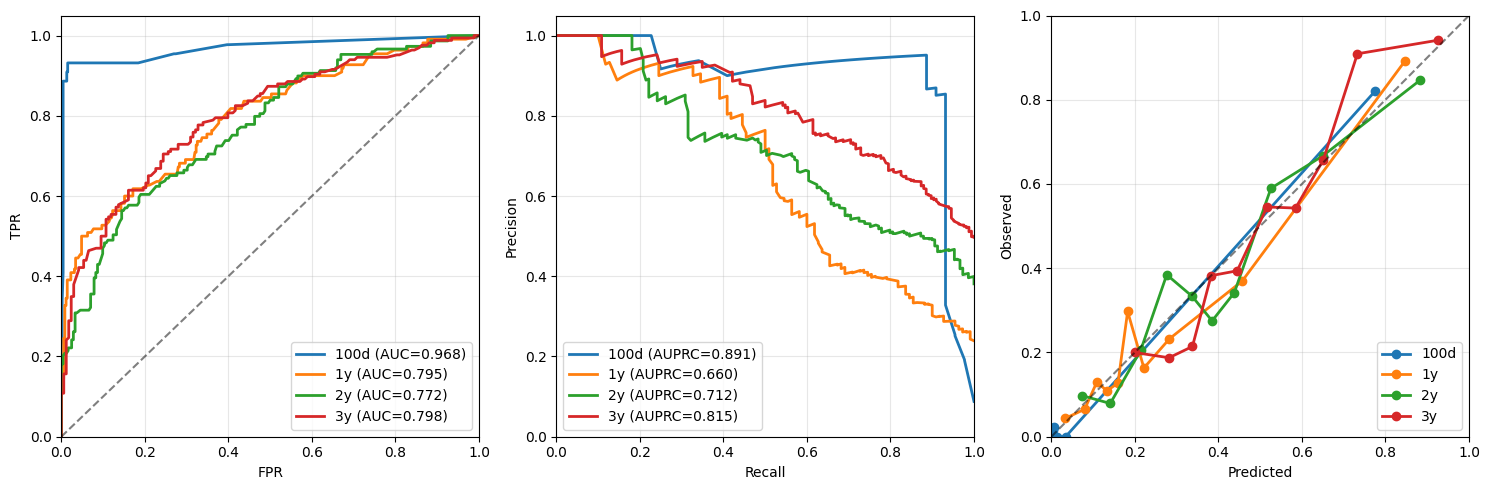

In [ ]:
plot_data = [(y_true, y_prob, hname) for hname, y_true, y_prob in all_results]

# Combined subplots (original behavior)
plot_performance_curves(plot_data)

# Separate plots  
plot_performance_curves(plot_data, figsize=(5, 5), separate_plots=True, show_full_curves=True, save_prefix='outputs/performance_', filetype='tiff')


In [12]:
# Collect data the same way you call plot_roc_pr_cal now
# curve_data = [
#     (np.array(y_all_true_100d), np.array(y_all_prob_100d), '100d (RandomForest)'),
#     (np.array(y_all_true_1y), np.array(y_all_prob_1y), '1y (GradBoost)'),
#     (np.array(y_all_true_2y), np.array(y_all_prob_2y), '2y (LogReg)'),
#     (np.array(y_all_true_3y), np.array(y_all_prob_3y), '3y (GradBoost)')
# ]

# plot_roc_pr_cal_combined(curve_data)

In [13]:
# # Plot confusion matrices using honest CV predictions
# from sklearn.metrics import ConfusionMatrixDisplay

# # We need to modify the training loop to save CV predictions for each horizon
# # Let's create a version that saves the honest CV predictions

# cv_predictions = {}  # Store CV predictions for each horizon

# print("Creating confusion matrices using honest cross-validation predictions...")
# print("Note: These use test fold predictions that were never seen during training/tuning")

# for hname, T in HORIZONS.items():
#     print(f'\n=== {hname} Horizon Confusion Matrix ===')
#     y = make_labels(df, T)
#     m = ~y.isna()
#     Xh, yh = X[m], y[m].astype(int)

#     pre = make_preprocessor(Xh)
#     models, grids = make_models_and_grids()
#     outer = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

#     y_cv_prob, y_cv_true = [], []

#     # Recreate the CV predictions (same logic as training loop)
#     for k, (tr, te) in enumerate(outer.split(Xh, yh), start=1):
#         Xtr, Xte = Xh.iloc[tr], Xh.iloc[te]
#         ytr, yte = yh.iloc[tr], yh.iloc[te]

#         best_auc, best_model = -np.inf, None
#         for mname, clf in models.items():
#             pipe = Pipeline([('prep', pre), ('clf', clf)])
#             gs = GridSearchCV(pipe, grids[mname], scoring='roc_auc', 
#                             cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=42), 
#                             n_jobs=-1, refit=True)
#             gs.fit(Xtr, ytr)
#             cal = CalibratedClassifierCV(gs.best_estimator_, cv=3, method='isotonic')
#             cal.fit(Xtr, ytr)
#             yprob = cal.predict_proba(Xte)[:,1]
#             auc = roc_auc_score(yte, yprob)
#             if auc > best_auc:
#                 best_auc, best_model = auc, cal

#         # Collect honest test predictions
#         yprob = best_model.predict_proba(Xte)[:,1]
#         y_cv_prob.extend(yprob.tolist())
#         y_cv_true.extend(yte.tolist())

#     # Create confusion matrix from honest CV predictions
#     y_cv_pred = (np.array(y_cv_prob) >= 0.5).astype(int)
    
#     # Store for potential later use
#     cv_predictions[hname] = {
#         'y_true': y_cv_true, 
#         'y_prob': y_cv_prob, 
#         'y_pred': y_cv_pred
#     }
    
#     # Plot confusion matrix
#     disp = ConfusionMatrixDisplay.from_predictions(
#         y_cv_true, y_cv_pred, 
#         cmap=plt.cm.Blues, 
#         normalize=None,
#         display_labels=['Survived', 'Died']
#     )
#     disp.ax_.set_title(f'Honest CV Confusion Matrix - {hname} Horizon')
#     plt.tight_layout()
#     plt.show()
    
#     # Print some summary stats
#     from sklearn.metrics import classification_report
#     print(f"Classification Report for {hname}:")
#     print(classification_report(y_cv_true, y_cv_pred, target_names=['Survived', 'Died']))
    
#     # Performance metrics
#     honest_metrics = evaluate(np.array(y_cv_true), np.array(y_cv_prob), y_cv_pred)
#     print(f"\nHonest Performance Metrics:")
#     print(f"AUROC: {honest_metrics['AUROC']:.3f}")
#     print(f"Accuracy: {honest_metrics['Accuracy']:.3f}")
#     print(f"Precision: {honest_metrics['Precision']:.3f}")
#     print(f"Recall: {honest_metrics['Recall']:.3f}")
#     print(f"F1-Score: {honest_metrics['F1']:.3f}")
#     print("-" * 50)

Loading model for 100D horizon...
Transforming features...
Creating SHAP explainer for RandomForestClassifier...
Computing SHAP values...
Using SHAP values for positive class (class 1)
Plot saved to: outputs/shap_100d.tiff


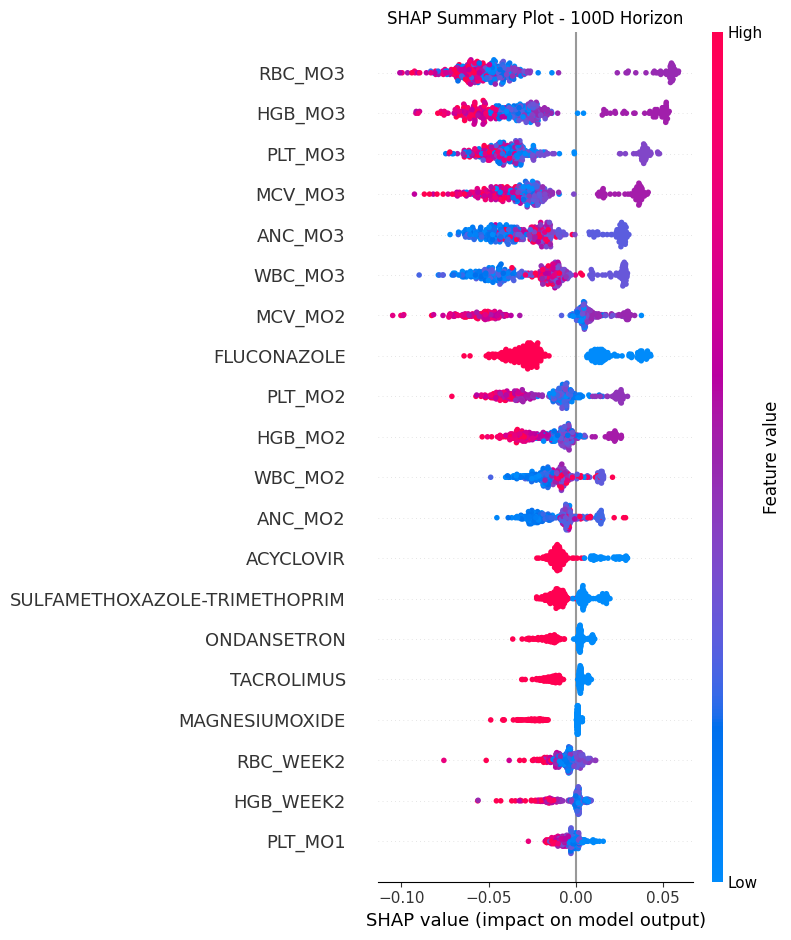

✓ SHAP analysis complete for 100D horizon
  Model type: RandomForestClassifier
  Features: 129, Samples: 334
Loading model for 1Y horizon...
Transforming features...
Creating SHAP explainer for GradientBoostingClassifier...
Computing SHAP values...
Using raw SHAP values
Plot saved to: outputs/shap_1y.tiff


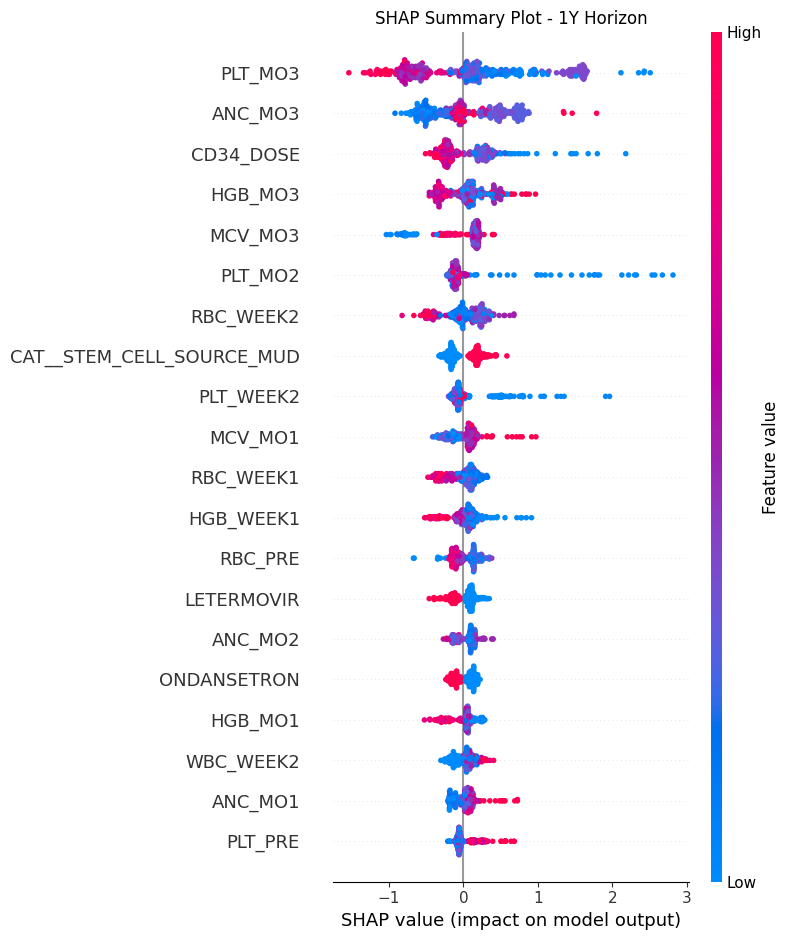

✓ SHAP analysis complete for 1Y horizon
  Model type: GradientBoostingClassifier
  Features: 126, Samples: 334
Loading model for 2Y horizon...
Transforming features...
Creating SHAP explainer for RandomForestClassifier...
Computing SHAP values...
Using SHAP values for positive class (class 1)
Plot saved to: outputs/shap_2y.tiff


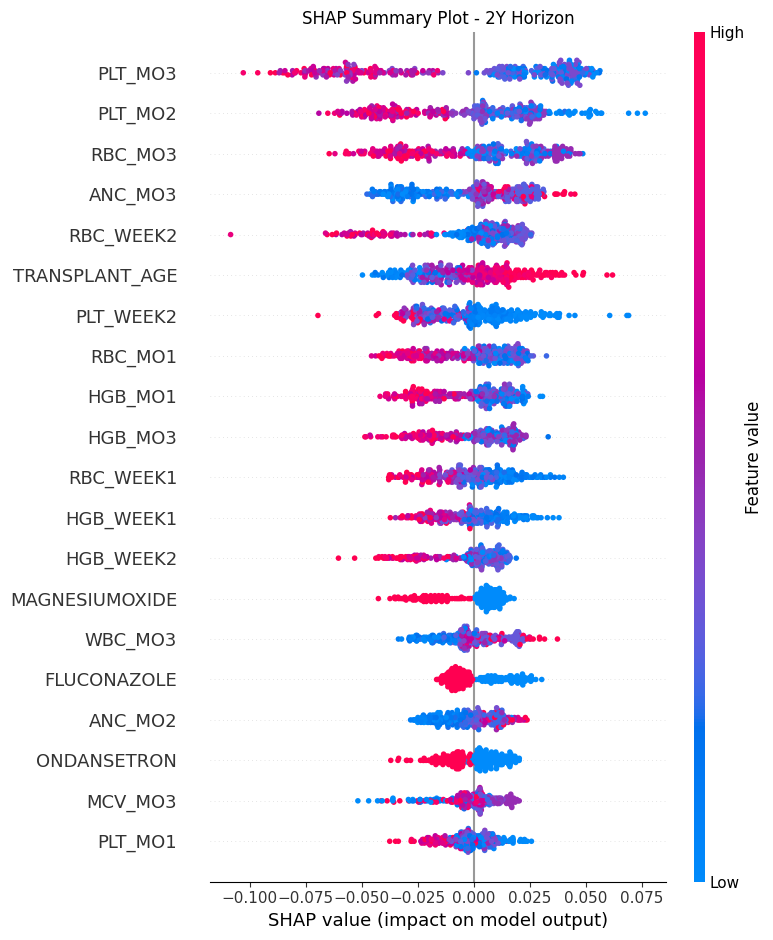

✓ SHAP analysis complete for 2Y horizon
  Model type: RandomForestClassifier
  Features: 124, Samples: 334
Loading model for 3Y horizon...
Transforming features...
Creating SHAP explainer for RandomForestClassifier...
Computing SHAP values...
Using SHAP values for positive class (class 1)
Plot saved to: outputs/shap_3y.tiff


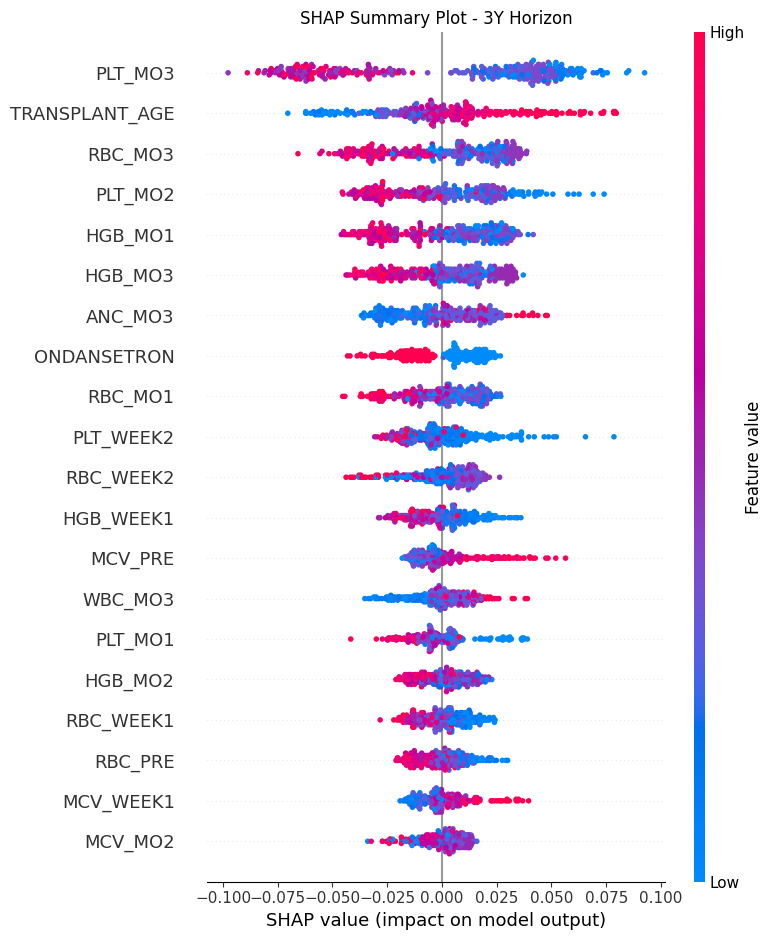

✓ SHAP analysis complete for 3Y horizon
  Model type: RandomForestClassifier
  Features: 123, Samples: 334


In [14]:
from allosurv.allosurv import plot_shap_for_horizon
# plot_shap_all_horizons

# Basic usage
# plot_shap_for_horizon(best_models, '3y', Xh)

# All horizons with bar charts
# plot_shap_all_horizons(best_models, Xh, plot_type='bar', max_display=15)

# Save individual plots
for horizon in ['100d', '1y', '2y', '3y']:
    plot_shap_for_horizon(best_models, horizon, Xh, save=True, filetype='tiff', save_prefix=f'outputs/shap_{horizon}'
                         )

In [15]:
# # perform shap analysis on the best model for 3y horizon
# best_model_3y = joblib.load(best_models['3y'])
# pipeline = best_model_3y.estimator
# X_transformed = pipeline.named_steps['prep'].transform(Xh)

# clf = pipeline.named_steps['clf']
# if isinstance(clf, (RandomForestClassifier, GradientBoostingClassifier)):
#     explainer = shap.TreeExplainer(clf)
# else:
#     explainer = shap.Explainer(clf, X_transformed)

# shap_values = explainer(X_transformed)
# feature_names = pipeline.named_steps['prep'].get_feature_names_out()
# clean_feature_names = [name.replace('num__','').replace('cat__oh__','') for name in feature_names]
# all_caps = [name.upper() for name in clean_feature_names]


# shap_values_class1 = shap_values.values[:, :, 1]
# shap.summary_plot(shap_values_class1, X_transformed, feature_names=all_caps, show=False, max_display=20)
# plt.title('SHAP Summary Plot for 3Y Horizon Model')
# plt.show()